### Data preprocessing and preparation

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['marketdata_sample.csv', 'news_sample.csv']


In [2]:
# load data from twosigma
from kaggle.competitions import twosigmanews
env = twosigmanews.make_env()
(marketdf, newsdf) = env.get_training_data()

Loading the data... This could take a minute.
Done!


In [3]:
# import needed libraries 
import lightgbm as lgb
import matplotlib.pyplot as plt
from datetime import datetime, date
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
import time

# data shape
print(marketdf.shape, newsdf.shape)

(4072956, 16) (9328750, 35)


In [4]:
# peak into the market data
marketdf.head().T

,0,1,2,3,4
time,2007-02-01 22:00:00+00:00,2007-02-01 22:00:00+00:00,2007-02-01 22:00:00+00:00,2007-02-01 22:00:00+00:00,2007-02-01 22:00:00+00:00
assetCode,A.N,AAI.N,AAP.N,AAPL.O,ABB.N
assetName,Agilent Technologies Inc,AirTran Holdings Inc,Advance Auto Parts Inc,Apple Inc,ABB Ltd
volume,2.6069e+06,2.0516e+06,1.1648e+06,2.37473e+07,1.2086e+06
close,32.19,11.12,37.51,84.74,18.02
open,32.17,11.08,37.99,86.23,18.01
returnsClosePrevRaw1,0.0059375,0.00451671,-0.0115942,-0.0115479,0.0117911
returnsOpenPrevRaw1,0.0053125,-0.00716846,0.0256479,0.0163239,0.0250427
returnsClosePrevMktres1,NaN,NaN,NaN,NaN,NaN
returnsOpenPrevMktres1,NaN,NaN,NaN,NaN,NaN


In [5]:
#peak into the news data
newsdf.head().T

,0,1,2,3,4
time,2007-01-01 04:29:32+00:00,2007-01-01 07:03:35+00:00,2007-01-01 11:29:56+00:00,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00
sourceTimestamp,2007-01-01 04:29:32+00:00,2007-01-01 07:03:34+00:00,2007-01-01 11:29:56+00:00,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00
firstCreated,2007-01-01 04:29:32+00:00,2007-01-01 07:03:34+00:00,2007-01-01 11:29:56+00:00,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00
sourceId,e58c6279551b85cf,5a31c4327427f63f,1cefd27a40fabdfe,23768af19dc69992,23768af19dc69992
headline,China's Daqing pumps 43.41 mln tonnes of oil i...,"FEATURE-In kidnapping, finesse works best",PRESS DIGEST - Wall Street Journal - Jan 1,PRESS DIGEST - New York Times - Jan 1,PRESS DIGEST - New York Times - Jan 1
urgency,3,3,3,3,3
takeSequence,1,1,1,1,1
provider,RTRS,RTRS,RTRS,RTRS,RTRS
subjects,"{'ENR', 'ASIA', 'CN', 'NGS', 'EMRG', 'RTRS', '...","{'FEA', 'CA', 'LATAM', 'MX', 'INS', 'ASIA', 'I...","{'RET', 'ENR', 'ID', 'BG', 'US', 'PRESS', 'IQ'...","{'FUND', 'FIN', 'CA', 'SFWR', 'INS', 'PUB', 'B...","{'FUND', 'FIN', 'CA', 'SFWR', 'INS', 'PUB', 'B..."
audiences,"{'Z', 'O', 'OIL'}","{'PGE', 'PCO', 'G', 'ESN', 'MD', 'PCU', 'DNP',...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD..."


In [6]:
marketdf.describe().round(3)

,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
count,4.072956e+06,4072956.000,4072956.000,4072956.000,4072956.000,4056976.000,4056968.000,4072956.000,4072956.000,3979946.000,3979902.000,4072956.000,4072956.000
mean,2.665312e+06,39.712,39.712,0.001,0.010,0.000,0.009,0.005,0.014,0.002,0.015,0.014,0.595
std,7.687606e+06,42.288,42.611,0.037,7.084,0.033,6.969,0.089,7.124,0.075,7.286,7.242,0.491
min,0.000000e+00,0.070,0.010,-0.978,-1.000,-1.236,-615.846,-0.977,-1.000,-3.343,-1375.045,-1375.045,0.000
25%,4.657968e+05,17.250,17.250,-0.011,-0.011,-0.009,-0.010,-0.033,-0.033,-0.029,-0.030,-0.030,0.000
50%,9.821000e+05,30.300,30.290,0.000,0.000,-0.000,-0.000,0.005,0.005,0.001,0.001,0.001,1.000
75%,2.403165e+06,49.860,49.850,0.012,0.012,0.008,0.010,0.043,0.043,0.031,0.032,0.032,1.000
max,1.226791e+09,1578.130,9998.990,45.592,9209.000,45.122,8989.207,46.672,9382.000,46.250,9761.338,9761.338,1.000


In [7]:
newsdf.describe().round(3)

,urgency,takeSequence,bodySize,companyCount,sentenceCount,wordCount,firstMentionSentence,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D
count,9328750.000,9328750.000,9328750.000,9328750.000,9328750.000,9328750.000,9328750.000,9328750.000,9328750.000,9328750.000,9328750.000,9328750.000,9328750.000,9328750.000,9328750.000,9328750.000,9328750.000,9328750.000,9328750.000,9328750.000,9328750.000,9328750.000,9328750.000
mean,2.321,2.123,3768.918,5.028,22.509,580.434,4.817,0.743,0.086,0.272,0.366,0.356,217.590,1.385,1.587,2.123,2.574,3.170,8.523,12.307,22.065,30.086,40.505
std,0.947,2.945,7475.653,8.788,36.020,958.059,12.177,0.381,0.826,0.286,0.245,0.259,388.556,8.221,8.534,10.715,12.956,16.572,29.303,34.369,54.319,69.902,89.486
min,1.000,1.000,0.000,1.000,1.000,1.000,0.000,0.001,-1.000,0.006,0.112,0.016,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,0.000,1.000,1.000,20.000,1.000,0.354,-1.000,0.034,0.139,0.172,20.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,2.000,3.000,4.000
50%,3.000,1.000,1571.000,1.000,10.000,259.000,1.000,1.000,0.000,0.149,0.300,0.248,85.000,0.000,0.000,0.000,0.000,0.000,4.000,5.000,8.000,10.000,13.000
75%,3.000,2.000,4504.000,5.000,30.000,765.000,2.000,1.000,1.000,0.533,0.583,0.552,245.000,2.000,2.000,2.000,2.000,2.000,9.000,13.000,22.000,30.000,41.000
max,3.000,97.000,122770.000,43.000,1205.000,20263.000,989.000,1.000,1.000,0.820,0.928,0.857,13087.000,500.000,500.000,500.000,500.000,500.000,2564.000,2569.000,2586.000,2599.000,2974.000


### Data cleansing

In [8]:
# replace outliers, which are the one with radical changes over one day, with mean values
marketdf['close_to_open'] =  np.abs(marketdf['close'] / marketdf['open'])
marketdf['assetName_mean_open'] = marketdf.groupby('assetName')['open'].transform('mean')
marketdf['assetName_mean_close'] = marketdf.groupby('assetName')['close'].transform('mean')
# if open price is too far from mean open price for this company, replace it. Otherwise replace close price.
for i, row in marketdf.loc[marketdf['close_to_open'] >= 2].iterrows():
    if np.abs(row['assetName_mean_open'] - row['open']) > np.abs(row['assetName_mean_close'] - row['close']):
        marketdf.iloc[i,5] = row['assetName_mean_open']
    else:
        marketdf.iloc[i,4] = row['assetName_mean_close']

for i, row in marketdf.loc[marketdf['close_to_open'] <= 0.5].iterrows():
    if np.abs(row['assetName_mean_open'] - row['open']) > np.abs(row['assetName_mean_close'] - row['close']):
        marketdf.iloc[i,5] = row['assetName_mean_open']
    else:
        marketdf.iloc[i,4] = row['assetName_mean_close']
marketdf.drop(['close_to_open','assetName_mean_open','assetName_mean_close'], axis=1, inplace=True)
print(marketdf.shape)

(4072956, 16)


In [9]:
# filter out strange data: platoe data or unknown assetcode
marketdf = marketdf[~marketdf.assetCode.isin(marketdf[marketdf.assetName=='Unknown'].assetCode.unique())]
marketdf = marketdf[marketdf.assetCode != 'PGN.N']
print(marketdf.shape)

(4048192, 16)


In [10]:
marketdf = marketdf[marketdf.assetCode != 'TW.N']

In [11]:
marketdf = marketdf[marketdf.assetCode != 'QRVO.O']

In [12]:
marketdf = marketdf[marketdf.assetCode != 'TECD.O']

In [13]:
# dropping EBR.N data in Oct 2016
marketdf = marketdf[~((marketdf['assetCode'] == 'EBR.N')& (marketdf['time'] >= '2016-10-01'))]

In [14]:
marketdf.describe().round(3)

,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
count,4.044339e+06,4044339.000,4044339.000,4044339.000,4044339.000,4028630.000,4028622.000,4044339.000,4044339.000,3952957.000,3952913.000,4044339.000,4044339.000
mean,2.672073e+06,39.786,39.783,0.001,0.010,0.000,0.009,0.005,0.014,0.002,0.015,0.014,0.595
std,7.709106e+06,42.375,42.373,0.037,7.109,0.032,6.993,0.087,7.148,0.073,7.310,7.268,0.491
min,0.000000e+00,0.250,0.010,-0.978,-1.000,-1.236,-615.846,-0.977,-1.000,-3.343,-1375.045,-1375.045,0.000
25%,4.671145e+05,17.320,17.320,-0.011,-0.011,-0.009,-0.010,-0.033,-0.033,-0.029,-0.030,-0.030,0.000
50%,9.846120e+05,30.330,30.330,0.000,0.000,-0.000,-0.000,0.005,0.005,0.001,0.001,0.001,1.000
75%,2.408378e+06,49.890,49.880,0.012,0.012,0.008,0.010,0.043,0.043,0.031,0.032,0.032,1.000
max,1.226791e+09,1578.130,1584.440,45.592,9209.000,45.122,8989.207,46.672,9382.000,46.250,9761.338,9761.338,1.000


### Data preparation

In [15]:
def prepare_data(marketdf, newsdf):
    # feature engineering
    # filter pre-2010 data because of unnormal behavior
    marketdf['time'] = marketdf.time.dt.strftime("%Y%m%d").astype(int)
    newsdf['time'] = newsdf.time.dt.strftime("%Y%m%d").astype(int)
    marketdf = marketdf.loc[marketdf['time'] > 20120000]
    newsdf = newsdf.loc[newsdf['time'] > 20120000]
    marketdf.sort_values(by=['time'])
    # market data 
    marketdf['average'] = (marketdf['close'] + marketdf['open'])/2
    marketdf['day_return'] = marketdf['close'] / marketdf['open']
    marketdf['prev_day_return'] = marketdf['returnsClosePrevMktres1'] / marketdf['returnsOpenPrevMktres1']
    marketdf['prev_10day_return'] = marketdf['returnsClosePrevMktres10'] / marketdf['returnsOpenPrevMktres10']
    marketdf['price_volume'] = marketdf['volume'] * marketdf['close']
    marketdf['volume_to_mean'] = marketdf['volume'] / marketdf['volume'].mean()
    marketdf['total_MACD'] = marketdf['close'].rolling(window=12).mean()-marketdf['close'].rolling(window=26).mean()
    marketdf['total_zscore'] = (marketdf['close']-marketdf['close'].rolling(window=200, min_periods=20).mean())/marketdf['close'].rolling(window=200, min_periods=20).std()
    # DIF-MACD
    ma_12 = lambda x: x.rolling(12).mean()
    ma_26 = lambda x: x.rolling(26).mean()
    marketdf['DIF'] = marketdf.groupby('assetCode')['close'].apply(ma_12)-marketdf.groupby('assetCode')['close'].apply(ma_26)
    marketdf['MACD'] = marketdf['DIF'].rolling(window=9).mean()
    marketdf['OSC'] = marketdf['DIF']-marketdf['MACD']
    # Z score: 200, 20
    zscore_fun_improved = lambda x:(x - x.rolling(window=15, min_periods=7).mean())/x.rolling(window=15, min_periods=7).std()
    marketdf['zscore'] = marketdf.groupby('assetCode')['close'].apply(zscore_fun_improved)
    # time series rolling based features: mean, std, ewm
    windows = [7,14]
    f = ['open','close','returnsOpenPrevMktres10', 'returnsClosePrevMktres10']
    for ff in f:
        for d in windows:
            marketdf['%s_%s_mean'%(ff,d)] = marketdf.groupby('assetCode')[ff].apply(lambda x: x.rolling(d).mean())
            marketdf['%s_%s_std'%(ff,d)] = marketdf.groupby('assetCode')[ff].apply(lambda x: x.rolling(d).std())
            marketdf['%s_%s_ewm'%(ff,d)] = marketdf.groupby('assetCode')[ff].transform(lambda x : pd.Series.ewm(x, span=d).mean())
    # news data
    newsdf['assetCode'] = newsdf['assetCodes'].map(lambda x: list(eval(x))[0])
    newsdf['position'] = newsdf['firstMentionSentence'] / newsdf['sentenceCount']
    newsdf['sentence_word_count'] =  newsdf['sentenceCount'] / newsdf['wordCount']
    # apply tf-idf on  news title
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.feature_extraction.text import TfidfTransformer
    from nltk.corpus import stopwords
    #the top hundred words.
    vectorizer = CountVectorizer(max_features=500, stop_words={"english"})
    #we do this with TF-IDF.
    X = vectorizer.fit_transform(newsdf['headline'].values)
    tf_transformer = TfidfTransformer(use_idf=False).fit(X)
    X_train_tf = tf_transformer.transform(X)
    X_train_vals = X_train_tf.mean(axis=1)
    del vectorizer
    del X
    del X_train_tf
    #mean tf-idf score for news article.
    d = pd.DataFrame(data=X_train_vals)
    newsdf['tf_score'] = d
    # drop extra junk from data
    droplist = ['sourceTimestamp','firstCreated','sourceId','headline','takeSequence','provider','firstMentionSentence',
                'sentenceCount','bodySize','headlineTag','marketCommentary','subjects','audiences','sentimentClass',
                'assetName', 'assetCodes','urgency','wordCount','sentimentWordCount']
    newsdf.drop(droplist, axis=1, inplace=True)
    marketdf.drop(['assetName', 'volume'], axis=1, inplace=True)
    # combine multiple news reports for same assets on same day
    newsgp = newsdf.groupby(['time','assetCode'], sort=False).aggregate(np.mean).reset_index()
    # join news reports to market data, note many assets will have many days without news data
    # encode assetcode
    lbl = {k: v for v, k in enumerate(marketdf['assetCode'].unique())}
    marketdf['assetCodeT'] = marketdf['assetCode'].map(lbl)
    return pd.merge(marketdf, newsgp, how='left', on=['time', 'assetCode'], copy=False) #, right_on=['time', 'assetCodes'])

In [16]:
print('preparing data...')
cdf = prepare_data(marketdf, newsdf)    
# add binary target variable
cdf['binary_returnsOpenNextMktres10'] = (cdf['returnsOpenNextMktres10'] > 0).astype(int)
del marketdf, newsdf  # save the memory
print(cdf.shape)

preparing data...


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

(2124135, 70)


In [17]:
# peak into new combined matrix 
cdf.head(3).T

,0,1,2
time,20120103,20120103,20120103
assetCode,A.N,AAN.N,AAP.N
close,36.48,26.63,69.1
open,35.84,27.23,71.14
returnsClosePrevRaw1,0.0443745,-0.00187406,-0.00761166
returnsOpenPrevRaw1,0.0260521,0,0.0159954
returnsClosePrevMktres1,0.0144484,-0.018074,-0.0190131
returnsOpenPrevMktres1,0.0286004,0.00123173,0.0169143
returnsClosePrevRaw10,0.090257,0.0164122,0.017061
returnsOpenPrevRaw10,0.0625556,0.0322214,0.0421827


In [18]:
# additional feature engineering: remove outlier, scaling
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures, MinMaxScaler, RobustScaler

def remove_outlier(df):
    low = .01
    high = .99
    quant_df = df.quantile([low, high])
    for name in list(df.columns):
        if is_numeric_dtype(df[name]) and name in ["close", "open"]:
            df = df[(df[name] > quant_df.loc[low, name]) & (df[name] < quant_df.loc[high, name])]
    return df

# remove outliers
print(cdf.shape)
cdf = remove_outlier(cdf)

(2124135, 70)


In [19]:
# train-val split
def get_input(cdf, option):
    # time series slice
    dates = cdf['time'].unique()
    train_dates = range(len(dates))[:int(0.85*len(dates))]
    val_dates = range(len(dates))[int(0.85*len(dates)):]
    # train cols
    traincols = [col for col in cdf.columns if col not in ['time', 'assetCode','universe','binary_returnsOpenNextMktres10', 'returnsOpenNextMktres10']]
    #cdf[targetcols[0]] = (cdf[targetcols[0]] > 0).astype(int)
    # build, x, y, t, u, d
    if option == "train":
        X = cdf[traincols].fillna(0).loc[cdf['time'].isin(dates[train_dates])].values
        Y = cdf['binary_returnsOpenNextMktres10'].fillna(0).loc[cdf['time'].isin(dates[train_dates])].values
        r = cdf['returnsOpenNextMktres10'].fillna(0).loc[cdf['time'].isin(dates[train_dates])].values
        u = cdf['universe'].loc[cdf['time'].isin(dates[train_dates])]
        d = cdf['time'].loc[cdf['time'].isin(dates[train_dates])]
    elif option == "val":
        X = cdf[traincols].fillna(0).loc[cdf['time'].isin(dates[val_dates])].values
        Y = cdf['binary_returnsOpenNextMktres10'].fillna(0).loc[cdf['time'].isin(dates[val_dates])].values
        r = cdf['returnsOpenNextMktres10'].fillna(0).loc[cdf['time'].isin(dates[val_dates])].values
        u = cdf['universe'].loc[cdf['time'].isin(dates[val_dates])]
        d = cdf['time'].loc[cdf['time'].isin(dates[val_dates])]
    return X,Y,r,u,d

In [20]:
# r, u and d are used to calculate the scoring metric
print('building training and validation set...')
Xt,Yt,r_train,u_train,d_train = get_input(cdf, "train")
Xv,Yv,r_val,u_val,d_val = get_input(cdf, "val")
print(Xt.shape, Yt.shape)
print(Xv.shape, Yv.shape)

building training and validation set...
(1748575, 65) (1748575,)
(332238, 65) (332238,)


### Modeling using lightGBM

In [21]:
# Modeling: LightGBM
print ('Training lightgbm')
evals_result = {}  # to record eval results for plotting

# parameters
params = {"objective" : "binary",
          "metric" : "binary_logloss",
          "num_leaves" : 600,
          "max_depth": -1,
          "learning_rate" : 0.001,
          "bagging_fraction" : 0.9,  # subsample
          "feature_fraction" : 0.9,  # colsample_bytree
          "bagging_freq" : 5,        # subsample_freq
          "bagging_seed" : 2018,
          "verbosity" : -1 }

lgtrain = lgb.Dataset(Xt, Yt) 
lgval = lgb.Dataset(Xv, Yv)
lgbmodel = lgb.train(params, lgtrain, 1000, valid_sets=[lgtrain, lgval], early_stopping_rounds=100, evals_result=evals_result, verbose_eval=10)

Training lightgbm
Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.692832	valid_1's binary_logloss: 0.692977
[20]	training's binary_logloss: 0.692521	valid_1's binary_logloss: 0.692831
[30]	training's binary_logloss: 0.692215	valid_1's binary_logloss: 0.692688
[40]	training's binary_logloss: 0.691917	valid_1's binary_logloss: 0.692548
[50]	training's binary_logloss: 0.691617	valid_1's binary_logloss: 0.692409
[60]	training's binary_logloss: 0.691324	valid_1's binary_logloss: 0.692276
[70]	training's binary_logloss: 0.691036	valid_1's binary_logloss: 0.692143
[80]	training's binary_logloss: 0.690754	valid_1's binary_logloss: 0.692015
[90]	training's binary_logloss: 0.690472	valid_1's binary_logloss: 0.691891
[100]	training's binary_logloss: 0.690195	valid_1's binary_logloss: 0.691768
[110]	training's binary_logloss: 0.689921	valid_1's binary_logloss: 0.69165
[120]	training's binary_logloss: 0.689653	valid_1's binary_logloss: 0.691533
[130]

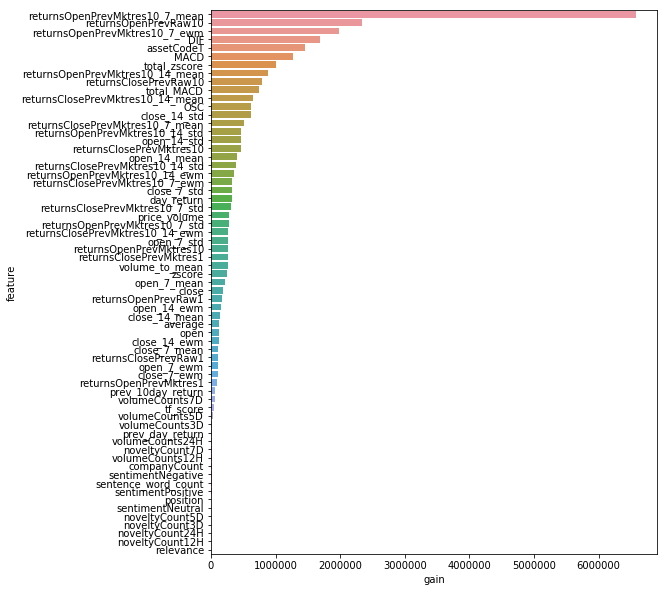

In [22]:
# plot feature importance of trained model
import seaborn as sns
feat_importance = pd.DataFrame()
traincols = [col for col in cdf.columns if col not in ['time', 'assetCode','universe','binary_returnsOpenNextMktres10', 'returnsOpenNextMktres10']]
feat_importance["feature"] = cdf[traincols].columns
feat_importance["gain"] = lgbmodel.feature_importance(importance_type='gain')
feat_importance.sort_values(by='gain', ascending=False, inplace=True)
plt.figure(figsize=(8,10))
ax = sns.barplot(y="feature", x="gain", data=feat_importance)

In [ ]:
# plot feature importance using SHAPE value
import shap
pd.set_option("display.max_columns", 96)
pd.set_option("display.max_rows", 96)

plt.rcParams['figure.figsize'] = (12, 9)
plt.style.use('ggplot')

shap.initjs()

# DF, based on which importance is checked
# Explain model predictions using shap library:
explainer = shap.TreeExplainer(lgbmodel)
shap_values = explainer.shap_values(Xv)

# Plot summary_plot
shap.summary_plot(shap_values, Xv)

Plotting metrics recorded during training...


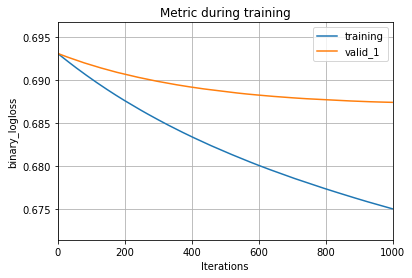

In [23]:
# plot loss function
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='binary_logloss')
plt.show()

Plotting tree...


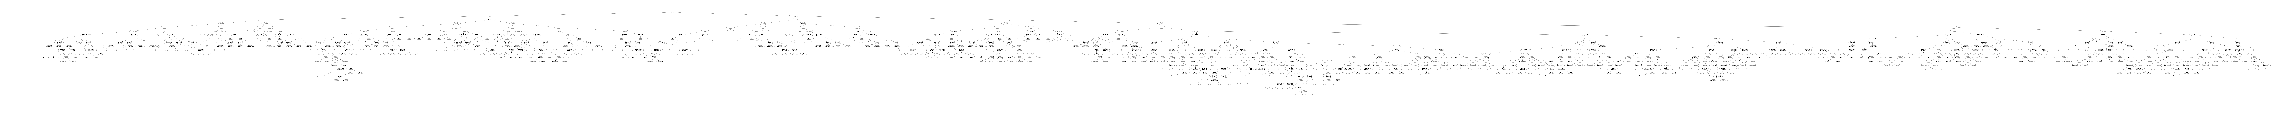

In [24]:
# plotting tree
print('Plotting tree...')  # one tree use categorical feature to split
ax = lgb.plot_tree(lgbmodel, tree_index=1, figsize=(40, 30), show_info=['split_gain'])
plt.show()

In [25]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaling function
def post_scaling(df):
    mean, std = np.mean(df), np.std(df)
    df = (df - mean)/ (std * 8)
    return np.clip(df,-1,1)

# another scaing fuction
def rescale(data_in, data_ref):
    scaler_ref =  StandardScaler()
    scaler_ref.fit(data_ref.reshape(-1,1))
    scaler_in = StandardScaler()
    data_in = scaler_in.fit_transform(data_in.reshape(-1,1))
    data_in = scaler_ref.inverse_transform(data_in)[:,0]
    return data_in

In [26]:
# see the distribution of prediction
predicted_return = lgbmodel.predict(Xv, num_iteration=lgbmodel.best_iteration) * 2 - 1
scaled_predicted_return = post_scaling(predicted_return)
scaled_predicted_return2 = rescale(predicted_return, r_train)

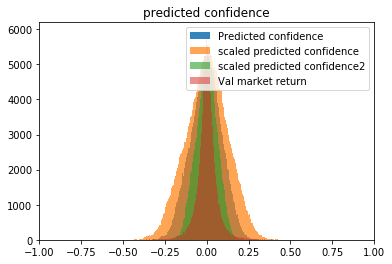

In [27]:
# plot distribution
# distribution of confidence that will be used as submission
plt.hist(predicted_return, bins='auto', alpha=0.9, label='Predicted confidence')
plt.hist(scaled_predicted_return, bins='auto', alpha=0.7, label='scaled predicted confidence')
plt.hist(scaled_predicted_return2, bins='auto', alpha=0.6, label='scaled predicted confidence2')
plt.hist(r_val, bins='auto',alpha=0.5, label='Val market return')
plt.title("predicted confidence")
plt.legend(loc='best')
plt.xlim(-1,1)
plt.show()

In [28]:
# calculation of actual metric that is used to calculate final score
r_val = r_val.clip(-1,1) # get rid of outliers.
#x_t_i = predicted_return * r_val * u_val
x_t_i = scaled_predicted_return * r_val * u_val
#x_t_i = scaled_predicted_return2 * r_val * u_val
data = {'day' : d_val, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
print(mean)
std = np.std(x_t)
print(std)
score_valid = mean / std
print('Validation score', score_valid)

0.6745503357712263
1.481655294565016
Validation score 0.4552680628521363


In [ ]:
'''
# generate predictions on testing data
print("generating predictions...")
preddays = env.get_prediction_days()
traincols = [col for col in cdf.columns if col not in ['time', 'assetCode', 'universe','binary_returnsOpenNextMktres10', 'returnsOpenNextMktres10']]
i = 0
for marketdf, newsdf, predtemplatedf in preddays:
    print(i)
    i+=1
    cdf = prepare_data(marketdf, newsdf)
    Xp = cdf[traincols].fillna(0).values
    preds = lgbmodel.predict(Xp, num_iteration=lgbmodel.best_iteration) * 2 - 1
    #preds = lgbmodel.predict(Xp, num_iteration=lgbmodel.best_iteration)
    predsdf = pd.DataFrame({'ast':cdf['assetCode'],'conf':post_scaling(preds)})
    predtemplatedf['confidenceValue'][predtemplatedf['assetCode'].isin(predsdf.ast)] = predsdf['conf'].values
    env.predict(predtemplatedf)
env.write_submission_file()

# submission file
import os
print([filename for filename in os.listdir('.') if '.csv' in filename])
'''